<a href="https://colab.research.google.com/github/Nawaphong-13/nawaphong-AI/blob/master/deep_computer_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# การเรียนรู้เชิงลึก (Deep Learning)
**Presented by: Nawaphong Yoochum**

![zax](https://instore.bnn.in.th/wp-content/uploads/2018/01/what-is-Artificial-Intelligence-ai-02.jpeg "zax")

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
import cv2
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

#A couple utility functions to plot grayscale and RGB images:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")


# ความแตกต่างระหว่าง Machine Learning และ Deep Learning
![zax](https://miro.medium.com/max/875/1*y5UsAjr5ZaKhZTrEMmwTaA.png "zax")

# Convolution Neural Network (CNN) 

**Figure 1.:Convolutional Neural Network Architecture**
![zax](https://miro.medium.com/max/875/1*kkyW7BR5FZJq4_oBTx3OPQ.png "zax")

# Convolutional Neural Network คืออะไร
***Convolutional Neural Network (CNN)*** หรือ โครงข่ายประสาทแบบคอนโวลูชัน เป็น **Neural Network (NN)** โดยที่ CNN จะจำลองการมองเห็นของมนุษย์ที่มองพื้นที่เป็นที่ย่อย ๆ และนำกลุ่มของพื้นที่ย่อยๆมาผสานกัน เพื่อดูว่าสิ่งที่เห็นอยู่เป็นอะไรกันแน่
การมองพื้นที่ย่อยของมนุษย์จะมีการแยกคุณลักษณะ (feature) ของพื้นที่
ย่อยนั้น เช่น ลายเส้น และการตัดกันของสี ซึ่งการที่มนุษย์รู้ว่าพื้นที่ตรงนี้เป็นเส้นตรงหรือสีตัดกัน เพราะมนุษย์ดูทั้งจุดที่สนใจและบริเวณรอบ ๆ ประกอบกัน

**Figure 1.:https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/**
![zax](https://miro.medium.com/max/875/1*9HPPZjXOem6afR9iSZgVcA.png "zax")

# Feature Extraction

แนวคิดของ CNN นั้นค่อนข้างเป็นแนวคิดที่ดีมาก แต่สิ่งที่ซับซ้อนของมันคือระบบการคำนวณที่สอดคล้องกับ Concept ของมันเองและต้องมีคณิตศาสตร์มารองรับ โดยการคำนวณตามแนวคิดนี้ใช้หลักการเดียวกันกับ **คอนโวลูชันเชิงพื้นที่ (Spatial Convolution)** ในการทำงานด้าน Image Processing
การคำนวณนี้จะเริ่มจากการกำหนดค่าใน **ตัวกรอง (filter) หรือ เคอร์เนล (kernel)** ที่ช่วยดึงคุณลักษณะที่ใช้ในการรู้จำวัตถุออก โดยปกติตัวกรอง/เคอร์เนลอันหนึ่งจะดึงคุณลักษณะที่สนใจออกมาได้หนึ่งอย่าง เราจึงจำเป็นต้องตัวกรองหลายตัวกรองด้วย เพื่อหาคุณลักษณะทางพื้นที่หลายอย่างประกอบกัน

### Load sample images

In [ ]:
import requests
from PIL import Image
import io

In [ ]:
url_bird = 'https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/02/bird.jpg'
url_cat = 'http://www.yespetshop.com/private_folder/kitten-1.jpg'
r_bird = requests.get(url_bird)
r_cat = requests.get(url_cat)

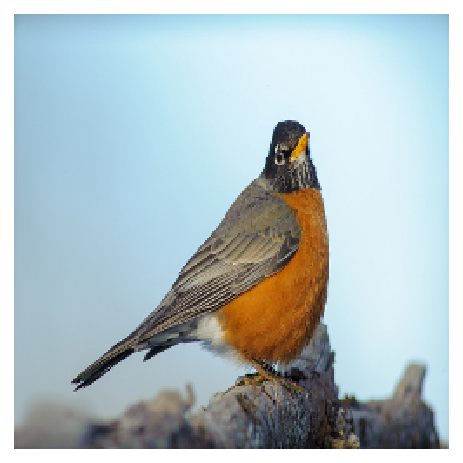

In [ ]:
img_bird = np.array(Image.open(io.BytesIO(r_bird.content)))
img_bird = cv2.resize(img_bird, (250,250))
plot_color_image(img_bird)

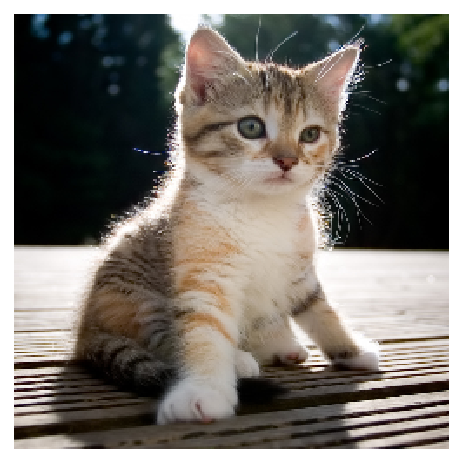

In [ ]:
img_cat = np.array(Image.open(io.BytesIO(r_cat.content)))
img_cat = cv2.resize(img_cat, (250,250))
plot_color_image(img_cat)

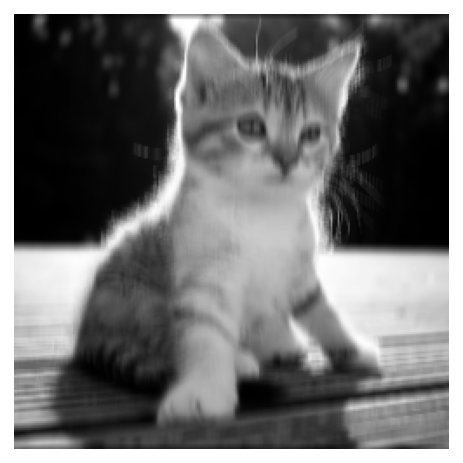

In [ ]:
# Load sample images
img_bird = np.array(img_bird) / 255
img_cat = np.array(img_cat) / 255
images = np.array([img_bird, img_cat])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[1, :, :, 0], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

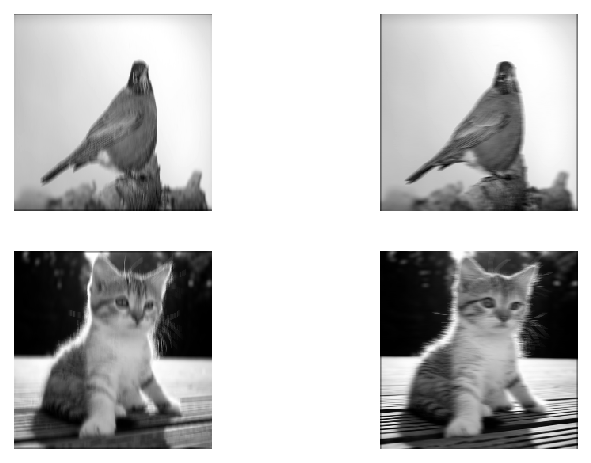

In [ ]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [ ]:
def crop(images):
    return images[30:100, 50:200]

Saving figure china_original


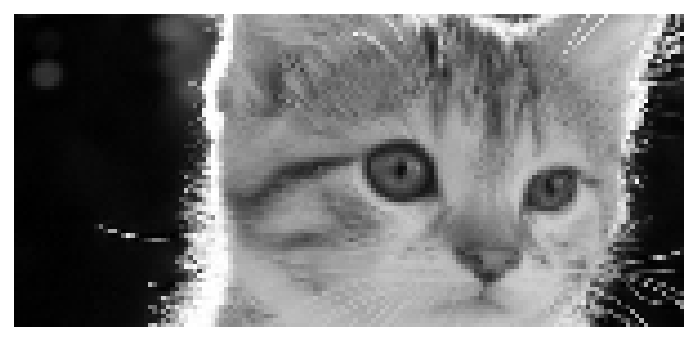

Saving figure china_vertical


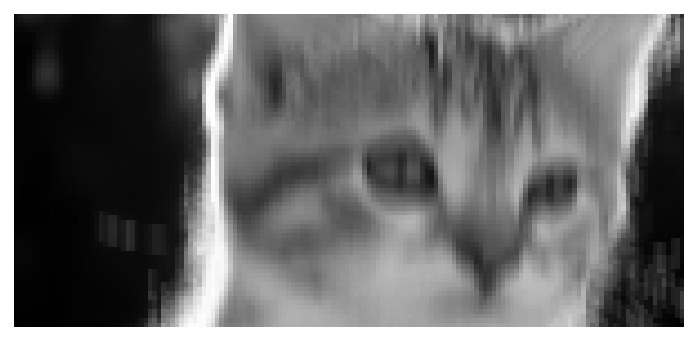

Saving figure china_horizontal


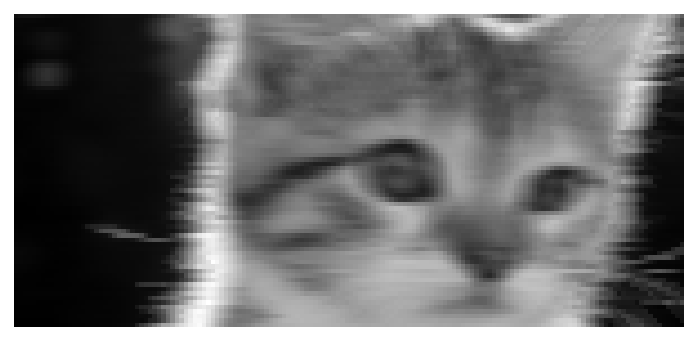

In [ ]:
plot_image(crop(images[1, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[1, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

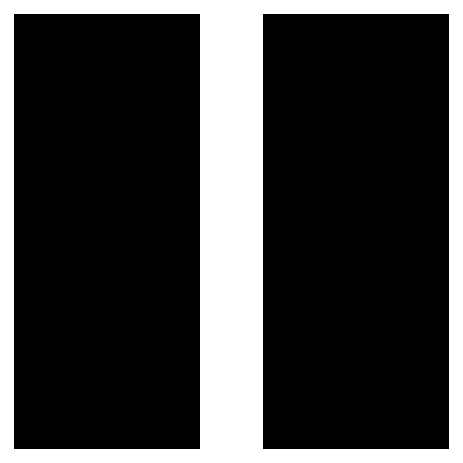

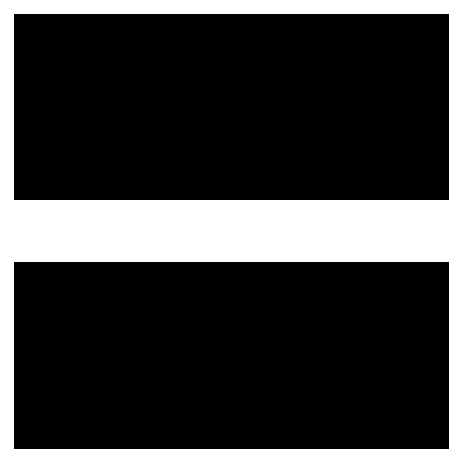

In [ ]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

## ลักษณะของ Filter

สำหรับ Filter ของภาพดิจิทัลนั้น โดยปกติแล้วจะเป็นตารางสองมิติที่มีขนาดตามพื้นที่ย่อยๆที่เราอยากพิจารณา
สมมุติว่าถ้าเราต้องการหาเส้นตรงทะแยงสีขาว ตัวกรองของเราอาจจะอยู่ในลักษณะนี้

**Figure 2.:ตัวกรอง 3x3 สำหรับหาเส้นตรงทะแยงสีขาว**
![zax](https://miro.medium.com/max/290/1*45ioU-IQBRoRYXezGbcjMQ.png "zax")

ตำแหน่งตรงกลางที่มีกรอบสีฟ้าคือ Anchor ที่เอาไว้ทาบบนพิกเซลของภาพข้อมูลเข้า ตัวกรองจะถูกทาบลงในพิกเซลแรกของภาพข้อมูลเข้า จากนั้นจะถูกเลื่อนไปทาบ
บนพิกเซลอื่นในภาพทีละพิกเซลจนครบทุกพิกเซลในภาพ เราอาจจะไม่ทาบตัวกรองบนพิกเซลที่อยู่ใกล้กรอบภาพ เพราะตัวกรองจะล้นออกไปนอกภาพ เมื่อเราเลื่อนตัวกรองไปเรื่อยๆจนครบทุกพิกเซลที่สามารถเลื่อนได้ในภาพ สิ่งที่เราได้นั้นจะเป็นสิ่งที่เรียกว่า **ผังคุณลักษณะ (feature map)**

**Figure 3.:ซ้าย: filter เลื่อนไปบน input. ขวา: ผลลัพธ์การคำนวณซึ่งออกมาเป็น Feature map. Source: https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2**
![zax](https://miro.medium.com/proxy/1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif "zax")

## Stride และ Padding

**Stride** เป็นตัวกำหนดว่าเราจะเลื่อนตัวกรอง (filter) ไปด้วย Step เท่าไร (ตัวอย่างด้านล่างกำหนด Stride เท่ากับ 1)

**Figure 4.:https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2**
![zax](https://miro.medium.com/proxy/1*L4T6IXRalWoseBncjRr4wQ@2x.gif "zax")

***เราสามารถกำหนดค่าของ Stride ให้มากขึ้นก็ได้ ถ้าเราต้องการให้การคำนวนหาคุณลักษณะมีพื้นที่ทับซ้อนกันน้อยขึ้น แต่อย่างไรก็ตามการกำหนดค่าของ Stride ที่มากขึ้นจะทำให้เราได้ผังคุณลักษณะ (feature map) ที่มีขนาดเล็กลง***

**Figure 5.: Stride เท่ากับ 2**
![zax](https://miro.medium.com/proxy/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif "zax")

**Padding** จากรูปด้านล่างเราจะพื้นที่สีเทารอบๆ Input พื้นที่เหล่านี้เป็นพื้นที่ที่เรามักเติมเข้าไป โดยอาจจะเป็นเติม 0 หรือค่าต่างๆเข้าไป เพื่อให้เวลาในการทำ CNN นั้น Feature Map ที่ได้ยังคงมีขนาดเท่ากับ Input

**Figure 6.: Padding = "same"**
![zax](https://miro.medium.com/proxy/1*W2D564Gkad9lj3_6t9I2PA@2x.gif "zax")

## Convolutional Layer in Keras API
* Using `keras.layers.Conv2D()` for ***Convolution Layer***

In [ ]:
cropped_images = np.array([img_bird, img_cat], dtype=np.float32)


In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

In [ ]:
output_conv = conv(cropped_images)

Saving figure china_max_pooling


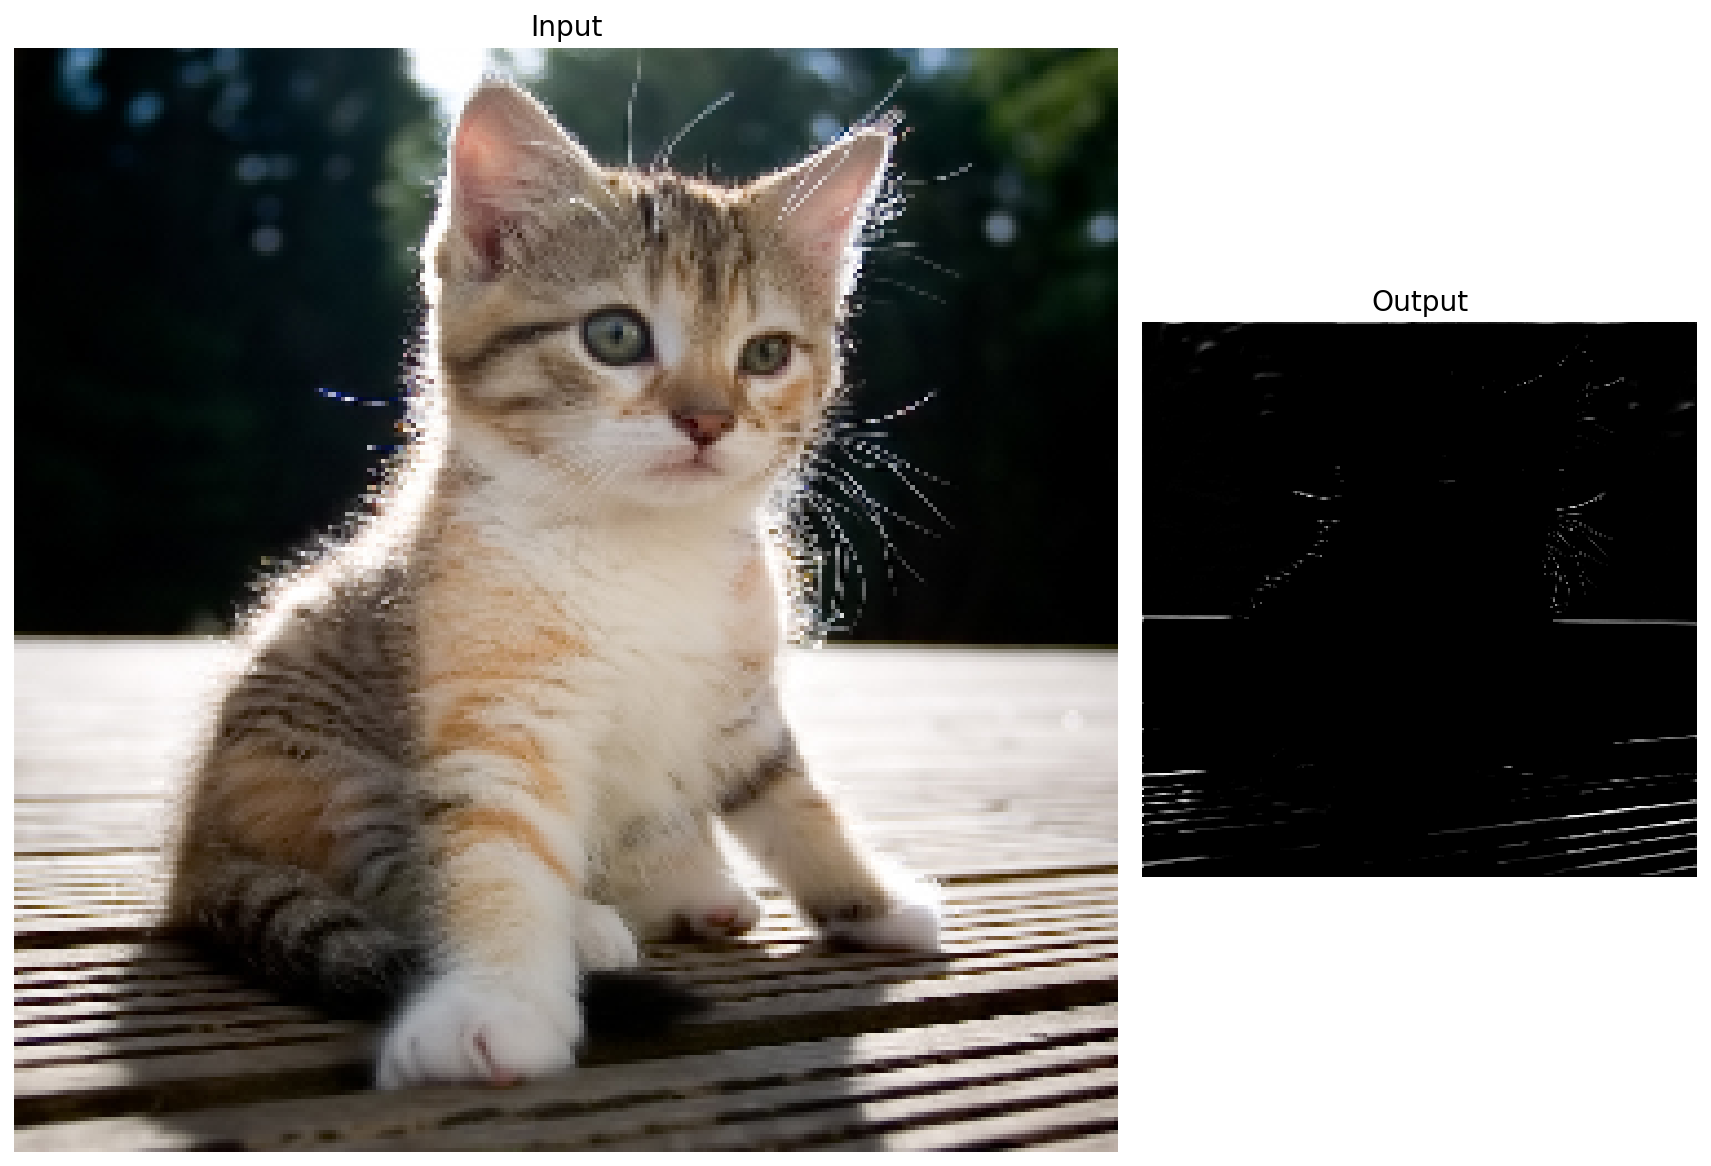

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[1])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_conv[1,:,:,17], cmap="gray", interpolation="nearest")  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

# Pooling layer in Keras API
* Using `keras.layers.AvgPool2D()` for ***Average pooling*** or `keras.layers.AvgPool2D()` ***Max pooling***

## Max pooling

In [ ]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [ ]:
output = max_pool(cropped_images)

In [ ]:
output.shape

TensorShape([2, 125, 125, 3])

Saving figure china_max_pooling


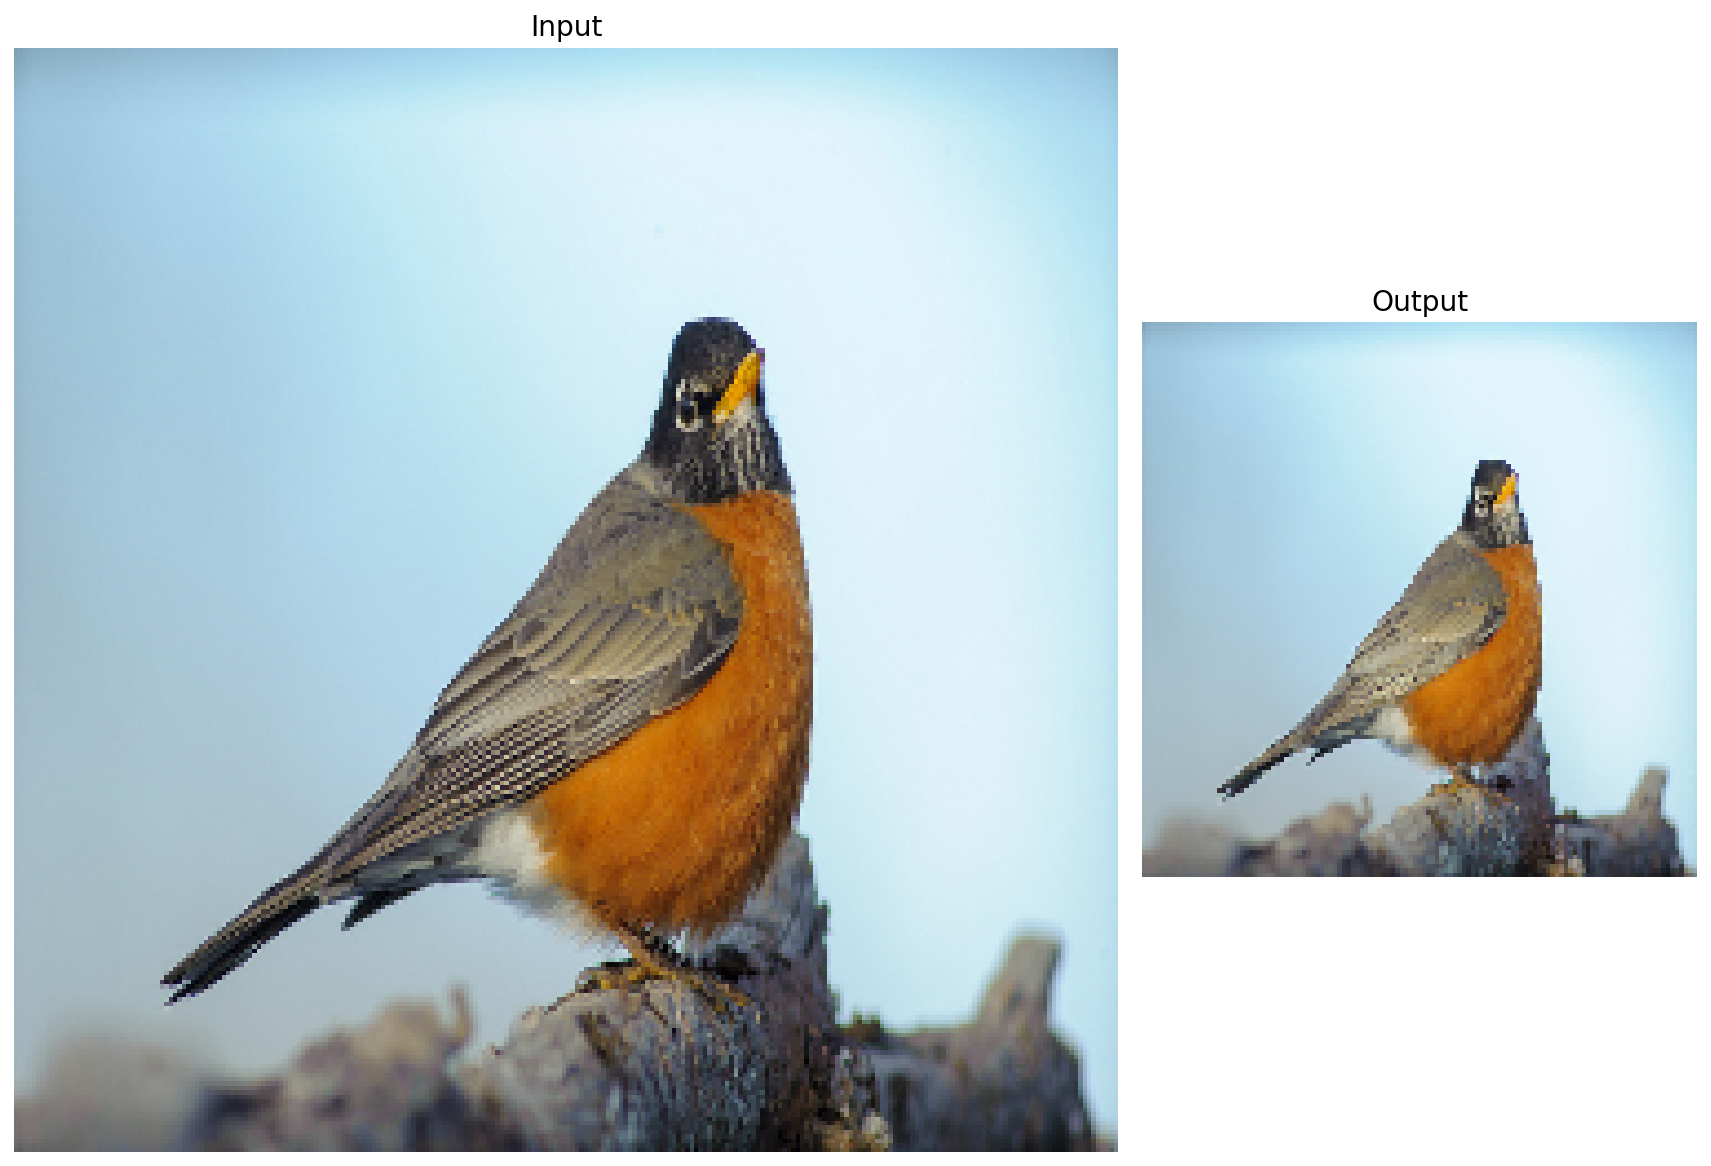

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## Average pooling

In [ ]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [ ]:
output_avg = avg_pool(cropped_images)

In [ ]:
output_avg.shape

TensorShape([2, 125, 125, 3])

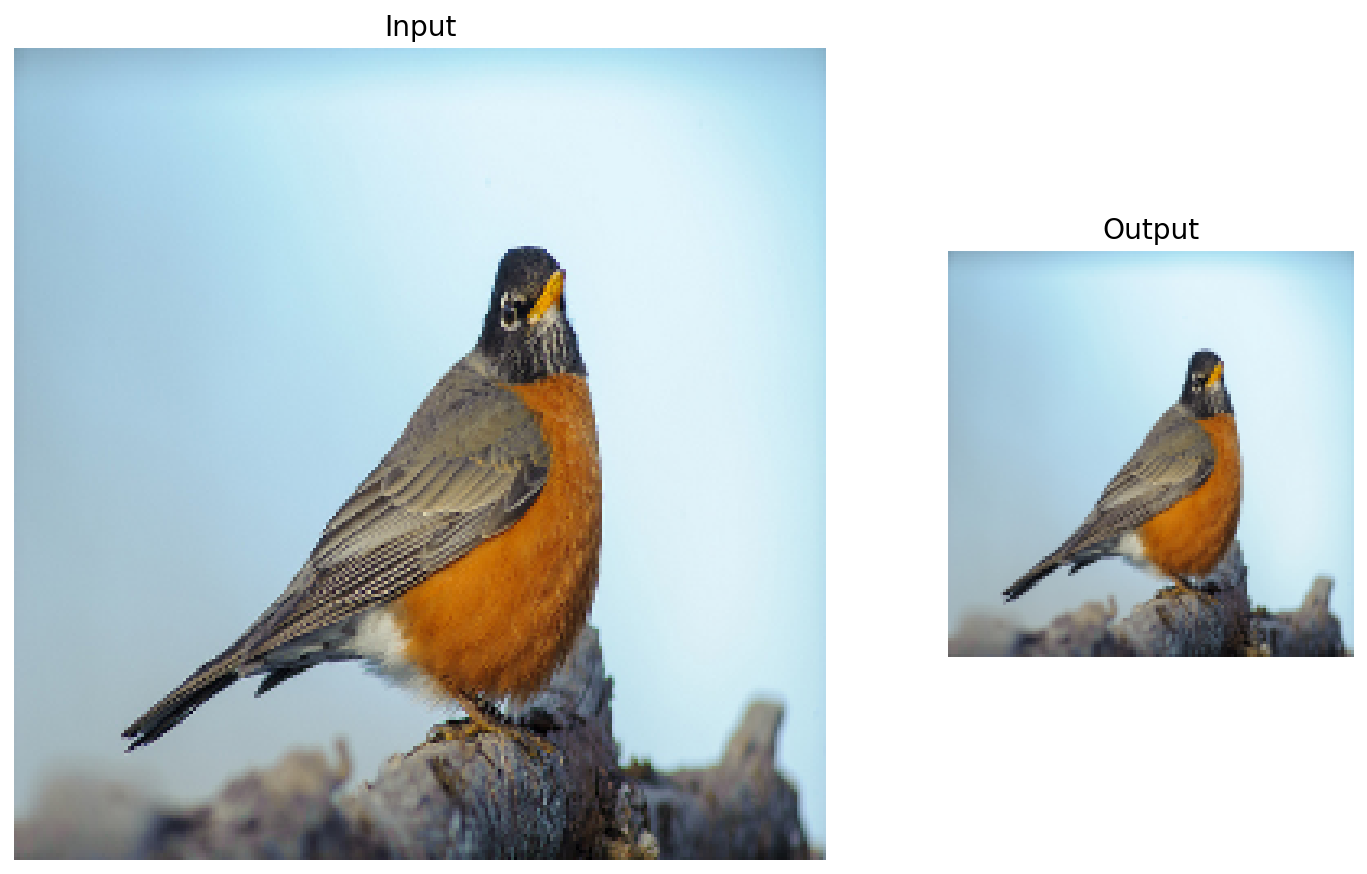

In [ ]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

# Tackling MNIST With a CNN

**Figure 6.: Mnist dataset**
![zax](https://i2.wp.com/syncedreview.com/wp-content/uploads/2019/06/MNIST.png?fit=530%2C297&ssl=1"zax")

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
X_train_full[0].shape

(28, 28)

In [ ]:
y_train_full

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [ ]:
X_train, X_valid, X_test = X_train/255, X_valid/255, X_test/255


In [ ]:
X_train.shape

(55000, 28, 28)

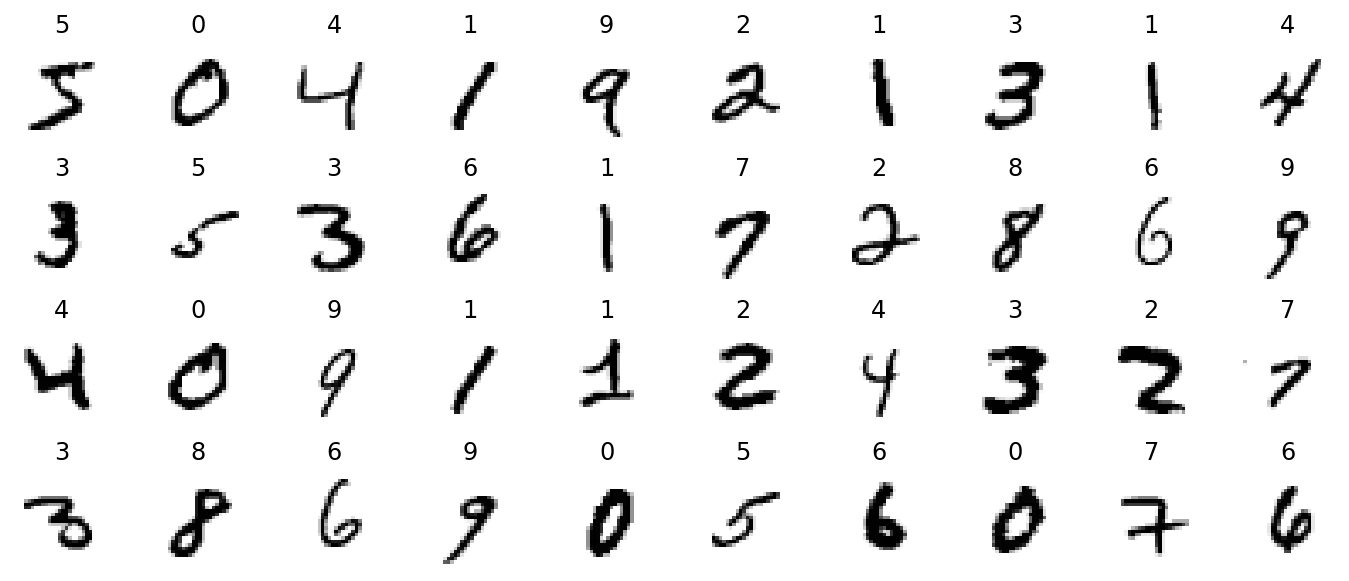

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(str(y_train[index]), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_train[0].shape

(28, 28, 1)

**Figure 6.: Example Architecture CNN**
![zax](https://miro.medium.com/max/3288/1*uAeANQIOQPqWZnnuH-VEyw.jpeg "zax")

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (5, 5), activation='relu', padding='valid', name='conv_1', 
                 input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D((2, 2), name='maxpool_1'))
model.add(keras.layers.Conv2D(64, (5, 5), activation='relu', padding='valid', name='conv_2'))
model.add(keras.layers.MaxPooling2D((2, 2), name='maxpool_2'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu', name='dense_1'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(10, activation='softmax', name='output'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 12, 12, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 8, 8, 64)          51264     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1674 - accuracy: 0.9479 - val_loss: 0.0422 - val_accuracy: 0.9876
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0549 - accuracy: 0.9834 - val_loss: 0.0397 - val_accuracy: 0.9884
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0408 - accuracy: 0.9871 - val_loss: 0.0386 - val_accuracy: 0.9906
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0307 - accuracy: 0.9905 - val_loss: 0.0330 - val_accuracy: 0.9924
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0318 - val_accuracy: 0.9918
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0359 - val_accuracy: 0.9930
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0292 - val_accuracy:

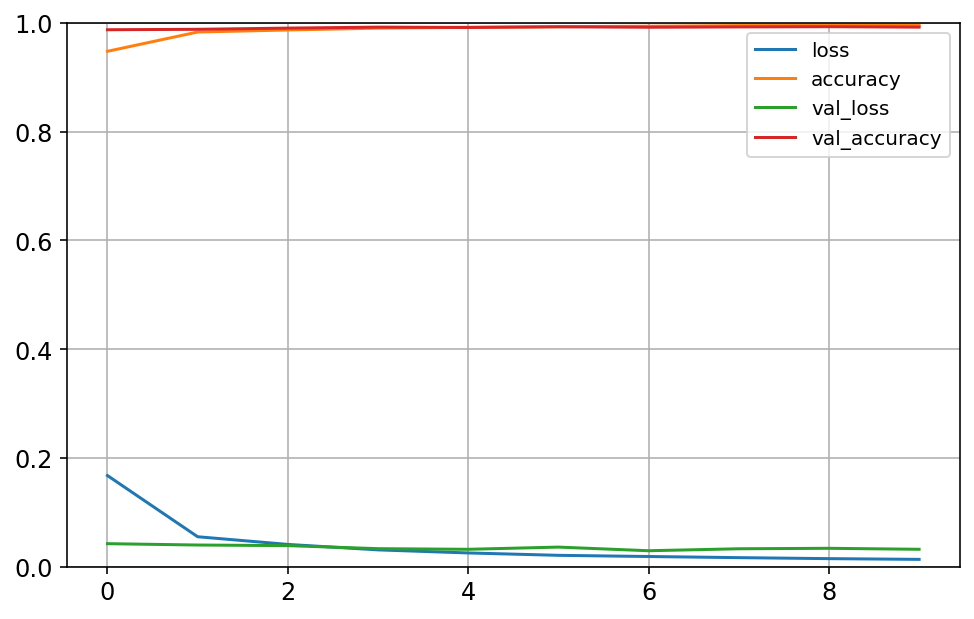

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0328 - accuracy: 0.9925


[0.032779887318611145, 0.9925000071525574]

[7270  860 5390 5191 5734]
Our model correctly classifies this image as a  1
Our model correctly classifies this image as a  6
Our model correctly classifies this image as a  2
Our model correctly classifies this image as a  4
Our model correctly classifies this image as a  3


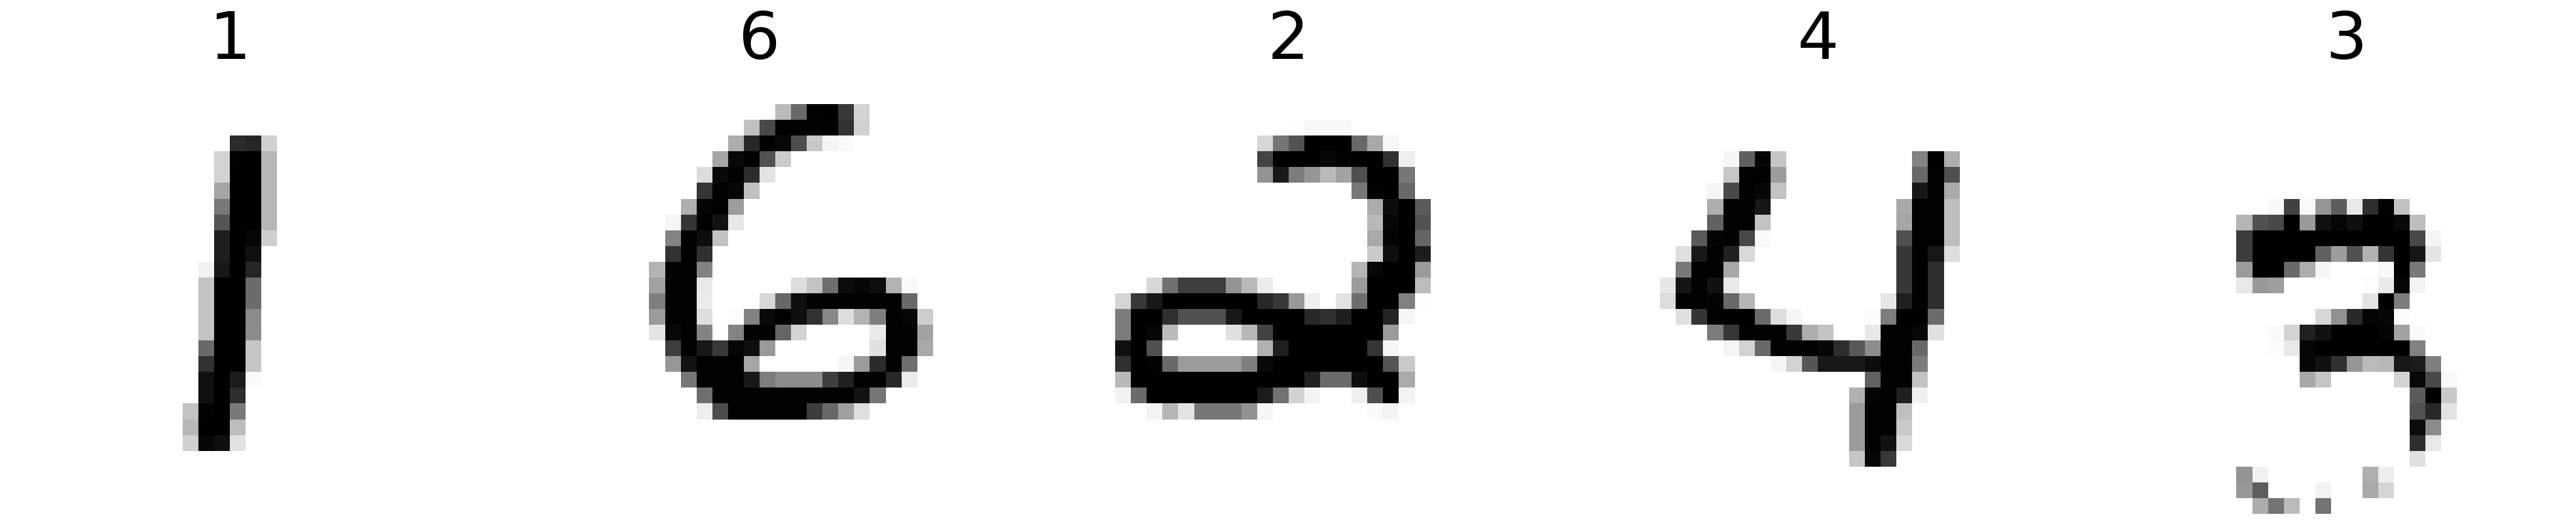

In [ ]:
n = 5
random_input = np.random.randint(X_test.shape[0], size = n)
print(random_input)
plt.figure(figsize = (35,35))

for i in range(n):
    pred = model.predict(X_test[random_input[i]].reshape(1, 28, 28, 1))
    print('Our model correctly classifies this image as a ', pred.argmax())
    plt.subplot(1, n, i+1)
    plt.imshow(X_test[random_input[i]].reshape(28, 28), cmap="binary", interpolation="nearest")
    plt.title(str(pred.argmax()),  fontsize=50)
    plt.axis('off')
    
plt.show()   

# Reference

* [Machine Learning](https://medium.com/mmp-li/%E0%B9%80%E0%B8%A3%E0%B8%B4%E0%B9%88%E0%B8%A1%E0%B9%80%E0%B8%A3%E0%B8%B5%E0%B8%A2%E0%B8%99-machine-learning-0-100-introduction-1c58e516bfcd).

* [Artificial Neural Network](https://medium.com/mmp-li/deep-learning-%E0%B9%81%E0%B8%9A%E0%B8%9A%E0%B8%89%E0%B8%9A%E0%B8%B1%E0%B8%9A%E0%B8%84%E0%B8%99%E0%B8%AA%E0%B8%B2%E0%B8%A1%E0%B8%B1%E0%B8%8D%E0%B8%8A%E0%B8%99-ep-1-neural-network-history-f7789236a9a3).

* [Convolutional Neural Network ](https://medium.com/@natthawatphongchit/%E0%B8%A1%E0%B8%B2%E0%B8%A5%E0%B8%AD%E0%B8%87%E0%B8%94%E0%B8%B9%E0%B8%A7%E0%B8%B4%E0%B8%98%E0%B8%B5%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%84%E0%B8%B4%E0%B8%94%E0%B8%82%E0%B8%AD%E0%B8%87-cnn-%E0%B8%81%E0%B8%B1%E0%B8%99-e3f5d73eebaa).

* [Machine Learning Notebooks: Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://github.com/ageron/handson-ml2).

* [Artificial Intelligence with Machine Learning, AI สร้างได้ด้วยแมชชีนเลิร์นนิ่ง](https://www.se-ed.com/product/Artificial-Intelligence-with-Machine-Learning-AI-%E0%B8%AA%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%87%E0%B9%84%E0%B8%94%E0%B9%89%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2%E0%B9%81%E0%B8%A1%E0%B8%8A%E0%B8%8A%E0%B8%B5%E0%B8%99%E0%B9%80%E0%B8%A5%E0%B8%B4%E0%B8%A3%E0%B9%8C%E0%B8%99%E0%B8%99%E0%B8%B4%E0%B9%88%E0%B8%87.aspx?no=9786164870710).

* [Python Image Processing Cookbook](https://github.com/PacktPublishing/Python-Image-Processing-Cookbook).